# Random Forest Rangers - Predicting Car Sales Prices
## Preprocessing

In [56]:
# Install dependencies
!pip install -q -r requirements.txt

In [57]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [58]:
train_original = pd.read_csv('data/0_Data_Split/train.csv')
train_generated_and_original = pd.read_csv('data/0_Data_Split/train_generated_and_original.csv')
test = pd.read_csv('data/0_Data_Split/test.csv')

# Array of all the dataframes
datasets = [train_original, train_generated_and_original, test]

### Ensure consistent data formatting

In [59]:
# Function to reformat numeric attributes with non-numeric elements such as currency symbols
def reformat_non_numeric(text):
    if isinstance(text, (float, int)):
        return text
    return float(re.sub(r'[^\d.]', '', text))

# Function to reformat the clean title column
def reformat_clean_title(text):
    return 1 if text == 'Yes' else 0

# Function to reformat the accident column
def reformat_accident(text):
    return 0 if text == '' or text == 'None reported' else 1

for dataset in datasets:
    # Reformat the existing columns
    dataset['clean_title'] = dataset['clean_title'].apply(reformat_clean_title)
    dataset['price'] = dataset['price'].apply(reformat_non_numeric)
    dataset['milage'] = dataset['milage'].apply(reformat_non_numeric)
    dataset['accident'] = dataset['accident'].apply(reformat_accident)

### Remove id column

In [60]:
for dataset in datasets:
    # Drop the columns that are not needed
    if 'id' in dataset.columns:
        dataset.drop(columns=['id'], inplace=True)

### Extract additional features

In [61]:
# Function to extract number of cylinders
def extract_cylinders(text):
    match = re.search(r'(\d+)\s*Cylinder', text, re.IGNORECASE)
    return int(match.group(1)) if match else None

# Function to extract horsepower
def extract_hp(text):
    match = re.search(r'(\d+(?:\.\d+)?)\s*HP', text, re.IGNORECASE)
    return float(match.group(1)) if match else None

# Function to extract cubic capacity
def extract_capacity(text):
    match = re.search(r'(\d+(?:\.\d+)?)\s*L', text, re.IGNORECASE)
    return float(match.group(1)) if match else None

# Function to extract whether the car has a turbo
def extract_turbo(text):
    match = re.search(r'Turbo', text, re.IGNORECASE)
    return 1 if match else 0

# Function to extract gear type
def extract_gear_type(text):
    match_automatic = re.search(r'Automatic|A/T', text, re.IGNORECASE)
    match_manual = re.search(r'Manual|M/T', text, re.IGNORECASE)
    if match_automatic:
        return 1
    elif match_manual:
        return 0
    else:
        return -1


# Function to extract the number of gears
def extract_gears(text):
    match = re.search(r'(\d+)-Speed\b', text, re.IGNORECASE)
    return int(match.group(1)) if match else None

# Function to extract whether the car has dual shift
def extract_dual_shift(text):
    match = re.search(r'Dual Shift', text, re.IGNORECASE)
    return 1 if match else 0

# Function to extract whether the car has a monochrome color
monochrome = ['Black', 'White', 'Silver', 'Gray']
def extract_monochrome_color(text):
    for color in monochrome:
        match = re.search(color, text, re.IGNORECASE)
        if match:
            return 1
    return 0

# Function to check if interior and exterior colors match
def extract_color_match(row):
    return 1 if row['ext_col'].lower() == row['int_col'].lower() else 0

# Function to extract if the car is a hybrid
def extract_hybrid(text):
    match = re.search(r'Hybrid', text, re.IGNORECASE)
    return 1 if match else 0

# Function to extract if the car is diesel
def extract_diesel(text):
    match = re.search(r'Diesel', text, re.IGNORECASE)
    return 1 if match else 0

# Function to extract if the car is gasolin
def extract_gasoline(text):
    match = re.search(r'Gasoline', text, re.IGNORECASE)
    return 1 if match else 0

# Function to extract if the car is electric
def extract_electric(text):
    match = re.search(r'Electric Motor', text, re.IGNORECASE)
    return 1 if match else 0
    
# Function to extract mileage per year
def extract_mileage_per_year(row):
    vehicle_age = 2024 - row['model_year']
    return row['milage'] / max(vehicle_age, 1)

for dataset in datasets:
    # Apply the extraction functions to create new columns
    dataset['cylinders'] = dataset['engine'].astype(str).apply(extract_cylinders)
    dataset['horsepower'] = dataset['engine'].astype(str).apply(extract_hp)
    dataset['cubic_capacity'] = dataset['engine'].astype(str).apply(extract_capacity)
    dataset['turbo'] = dataset['engine'].astype(str).apply(extract_turbo)
    dataset['is_automatic'] = dataset['transmission'].astype(str).apply(extract_gear_type)
    dataset['gears'] = dataset['transmission'].astype(str).apply(extract_gears)
    dataset['dual_shift'] = dataset['transmission'].astype(str).apply(extract_dual_shift)
    dataset['ext_col_mon'] = dataset['ext_col'].astype(str).apply(extract_monochrome_color)
    dataset['int_col_mon'] = dataset['int_col'].astype(str).apply(extract_monochrome_color)
    dataset['color_match'] = dataset.apply(lambda row: extract_color_match(row), axis=1)
    dataset['is_hybrid'] = dataset['fuel_type'].astype(str).apply(extract_hybrid)
    dataset['is_diesel'] = dataset['fuel_type'].astype(str).apply(extract_diesel)
    dataset['is_gasoline'] = dataset['fuel_type'].astype(str).apply(extract_gasoline)
    dataset['is_electric'] = dataset['engine'].astype(str).apply(extract_electric)
    #dataset['mileage_per_year'] = dataset.apply(lambda row: extract_mileage_per_year(row), axis=1)

### Remove outliers

In [62]:
for i, dataset in enumerate(datasets):
    # Calculate the z-scores of the price column
    z_scores = stats.zscore(dataset['price'])

    print(f"Remove {len(dataset) - len(dataset[(z_scores < 3)])} outliers from dataset")
    
    # Filter the dataset to remove rows where the z-score of the price is greater than 3
    dataset = dataset[(z_scores < 3)]

    datasets[i] = dataset

Remove 24 outliers from dataset
Remove 971 outliers from dataset
Remove 14 outliers from dataset


### Categorize brands

Emils Feature engineering: We create 2 more attribues called "Is_Luxury" and "Is_Upper_class". The former are brands which cars are above the 75th percentile 80% of the time. The later below 80% and above 50% of the time. The rest are considered to be normal.

In [63]:
# Define the bins for the Mileage categories
mileage_bins = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, float('inf')]
mileage_labels = ['<10k', '>10k<20k', '>20k<30k', '>30k<40k', '>40k<50k', '>50k<60k', '>60k<70k', '>70k<80k', '>80k<90k', '>90k<100k', '>100k']

# Function to filter cars above the 75th percentile for each brand
def filter_above_percentile(df, percentile_75):
    results = []
    
    for category, threshold in percentile_75.items():
        # Filter cars with Price > 75th percentile for the given category
        filtered = df[(df['milage_category'] == category) & (df['price'] > threshold)]
        
        # Calculate absolute and relative counts for each brand
        absolute_count = filtered.groupby('brand').size()
        total_count = df[df['milage_category'] == category].groupby('brand').size()
        relative_count = absolute_count / total_count
        
        # Store results
        for brand in absolute_count.index:
            results.append({
                'brand': brand,
                'milage_category': category,
                'Absolute_Above_75th': absolute_count[brand],
                'Relative_Above_75th': relative_count[brand]
            })
    
    return pd.DataFrame(results)

categories_above_80_percent = []
categories_above_50_below_80_percent = []

for i, dataset in enumerate(datasets):
    # Create dataframe copy
    dataset = dataset.copy()

    # Create the Mileage categories
    dataset.loc[:, 'milage_category'] = pd.cut(dataset['milage'], bins=mileage_bins, labels=mileage_labels, right=False)

    # Calculate the 75th percentile for price in each Mileage Category
    percentile_75 = dataset.groupby('milage_category', observed=True)['price'].quantile(0.75)

    # Filter and calculate the results
    filtered_results = filter_above_percentile(dataset, percentile_75)
    # Calculate the average of `Relative_Above_75th` for each Mileage Category
    category_avg = filtered_results.groupby('brand')['Relative_Above_75th'].mean()

    # Filter categories where the average is greater than 0.8 (80%)
    categories_above_80_percent.append(category_avg[category_avg > 0.8].to_frame())
    print(categories_above_80_percent)

    # Filter categories where the average is between 50% and 80%
    categories_above_50_below_80_percent.append(category_avg[(category_avg > 0.5) & (category_avg < 0.8)].to_frame())
    print(categories_above_50_below_80_percent)

[             Relative_Above_75th
brand                           
Aston                   0.833333
Bentley                 0.922449
Ferrari                 1.000000
Lamborghini             1.000000
Maybach                 1.000000
McLaren                 1.000000
Rolls-Royce             1.000000]
[         Relative_Above_75th
brand                       
Hummer              0.590909
Lincoln             0.506667
Porsche             0.608690
RAM                 0.605138
Tesla               0.607333]
[             Relative_Above_75th
brand                           
Aston                   0.833333
Bentley                 0.922449
Ferrari                 1.000000
Lamborghini             1.000000
Maybach                 1.000000
McLaren                 1.000000
Rolls-Royce             1.000000,          Relative_Above_75th
brand                       
Ferrari                  1.0
Lucid                    1.0
Maybach                  1.0
Rivian                   1.0]
[         Relative_Abo

In [64]:
for i, dataset in enumerate(datasets):
    # Create a copy of the dataset
    dataset = dataset.copy()

    luxury_brands = categories_above_80_percent[i].index.tolist()
    upper_class_brands = categories_above_50_below_80_percent[i].index.tolist()

    # Add the 'Is_Luxury' column: 1 if the brand is in the luxury list, otherwise 0
    dataset.loc[:, 'is_luxury'] = np.where(dataset['brand'].isin(luxury_brands), 1, 0)
    dataset.loc[:, 'is_upper_class'] = np.where(dataset['brand'].isin(upper_class_brands), 1, 0)

    datasets[i] = dataset

### Encode categorical features

In [65]:
for dataset in datasets:
    # Calculate the median prices per brand
    median_prices = dataset.groupby('brand')['price'].median()

    # Sort the brands based on the median prices
    sorted_brands = median_prices.sort_values()

    # Categorize the brands based on the median prices into 4 bins
    brand_bins = pd.qcut(sorted_brands, 4, labels=False)

    # Replace the brand names with the bin numbers
    dataset.loc[:, 'brand'] = dataset['brand'].map(lambda x: brand_bins[x])

### Compute pairwise correlations

<Axes: >

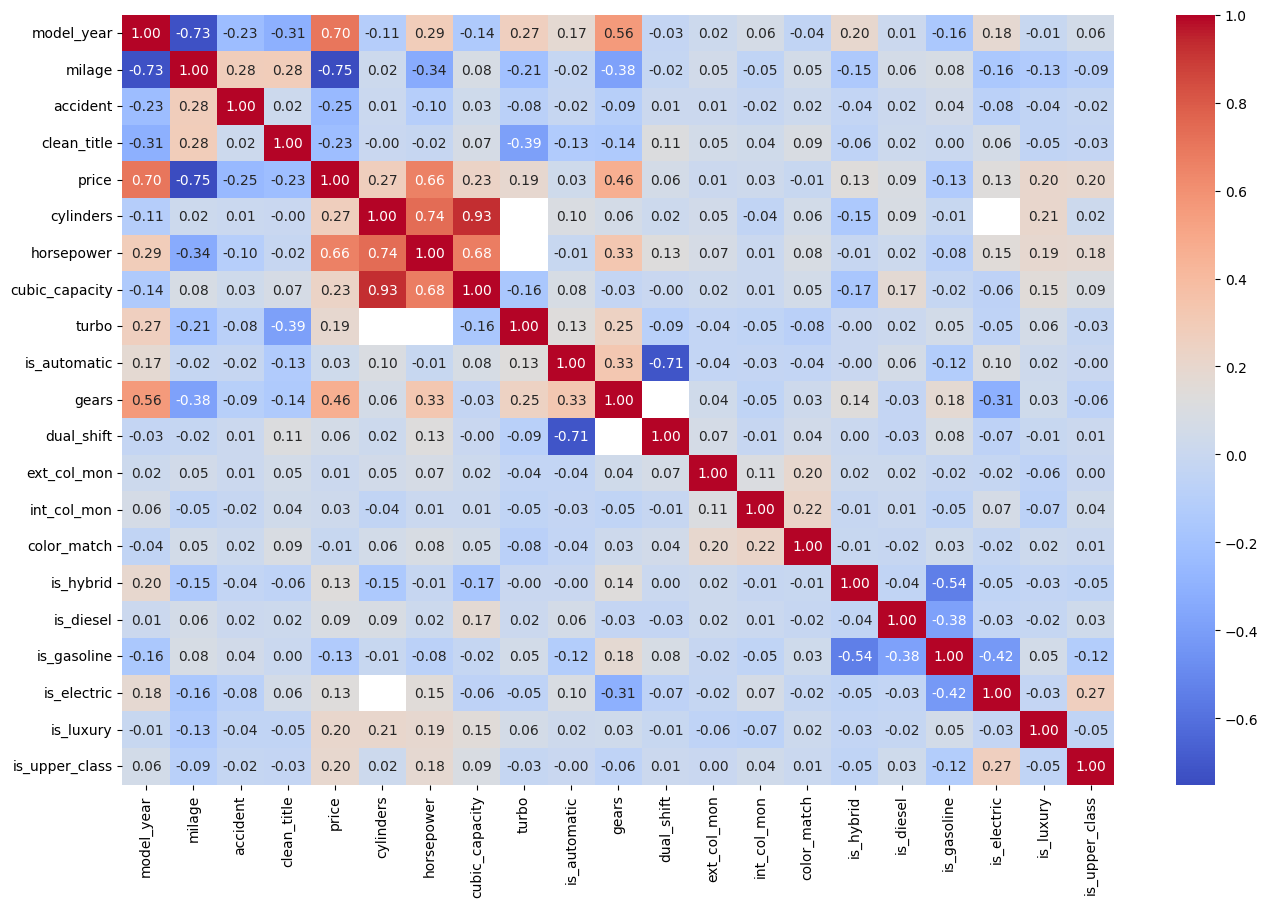

In [66]:
dataset = datasets[0] # Use the original training dataset

# Select only numeric columns
non_numeric_columns = dataset.select_dtypes(exclude=[np.number]).columns

# Drop non-numeric columns
dataset = dataset.drop(columns=non_numeric_columns)

# Calculate the Spearman correlation matrix
spearman_corr = dataset.corr(method='spearman')

# Plot the correlation matrix
plt.figure(figsize=(16, 10))
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap='coolwarm')

High correlations between:
- `Model_Year` and `Mileage`
- `Cylinders`, `Cubic_Capacity` and `Horsepower`

### Handle highly correlated features

Correlation between `cubic_capacity`, `horsepower` and `cylinders`.

In [67]:
dataset = datasets[0] # Use the original training dataset

# Calculate the number of rows with available values for horsepower, cubic_capacity, and cylinders
available_horsepower = dataset['horsepower'].notnull()
available_cubic_capacity = dataset['cubic_capacity'].notnull()
available_cylinders = dataset['cylinders'].notnull()

# Calculate the number of rows with available values
all_available = available_horsepower & available_cubic_capacity & available_cylinders
two_available = (available_horsepower & available_cubic_capacity & ~available_cylinders) | \
                (available_horsepower & ~available_cubic_capacity & available_cylinders) | \
                (~available_horsepower & available_cubic_capacity & available_cylinders)
one_available = (available_horsepower & ~available_cubic_capacity & ~available_cylinders) | \
                        (~available_horsepower & available_cubic_capacity & ~available_cylinders) | \
                        (~available_horsepower & ~available_cubic_capacity & available_cylinders)
none_available = ~(available_horsepower | available_cubic_capacity | available_cylinders)

# Calculate the number of rows with available values for horsepower, cubic_capacity, and cylinders
sum_all_available = all_available.sum()
sum_two_available = two_available.sum()
sum_one_available = one_available.sum()
sum_none_available = none_available.sum()

# Calculate the percentage of rows with available values for horsepower, cubic_capacity, and cylinders
percentage_all_available = sum_all_available / len(dataset) * 100
percentage_two_available = sum_two_available / len(dataset) * 100
percentage_one_available = sum_one_available / len(dataset) * 100
percentage_none_available = sum_none_available / len(dataset) * 100

print(f"Rows with all available values: {sum_all_available} ({percentage_all_available:.2f}%)")
print(f"Rows with two available values: {sum_two_available} ({percentage_two_available:.2f}%)")
print(f"Rows with one available value: {sum_one_available} ({percentage_one_available:.2f}%)")
print(f"Rows with no available values: {sum_none_available} ({percentage_none_available:.2f}%)")
print(f"Rows with at least one available value: {sum_all_available + sum_two_available + sum_one_available} ({percentage_all_available + percentage_two_available + percentage_one_available:.2f}%)")

Rows with all available values: 2453 (77.07%)
Rows with two available values: 12 (0.38%)
Rows with one available value: 651 (20.45%)
Rows with no available values: 67 (2.10%)
Rows with at least one available value: 3116 (97.90%)


In [68]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler

for i, dataset in enumerate(datasets):
    # Create a copy of the dataset to avoid SettingWithCopyWarning
    dataset = dataset.copy()
    
    # Step 1: Impute missing values
    imputer = KNNImputer(n_neighbors=3)
    dataset.loc[:, ['horsepower', 'cubic_capacity', 'cylinders']] = imputer.fit_transform(dataset[['horsepower', 'cubic_capacity', 'cylinders']])

    # Step 2: Normalize the features
    scaler = RobustScaler()
    dataset.loc[:, ['horsepower', 'cubic_capacity', 'cylinders']] = scaler.fit_transform(dataset[['horsepower', 'cubic_capacity', 'cylinders']])

    # Step 3: Calculate the synthetic variable
    dataset['engine_score'] = dataset[['horsepower', 'cubic_capacity', 'cylinders']].mean(axis=1).round(3)
    dataset.loc[dataset[['horsepower', 'cubic_capacity', 'cylinders']].isnull().all(axis=1), 'engine_score'] = 0

    datasets[i] = dataset
    

### Handle missing values

In [69]:
for i, dataset in enumerate(datasets):
    print(f"Missing values in dataset {i + 1}:\n")

    missing_values = dataset.isnull().sum()
    missing_values_percentage = missing_values / len(dataset) * 100

    missing_features = missing_values[missing_values > 0]
    missing_features_percentage = missing_values_percentage[missing_values > 0]
    print(pd.DataFrame({'Missing Values': missing_features, 'Percentage': missing_features_percentage}))
    print()

Missing values in dataset 1:

           Missing Values  Percentage
fuel_type             135    4.241282
gears                1490   46.811184

Missing values in dataset 2:

           Missing Values  Percentage
fuel_type             135    0.135287
gears               43893   43.986251

Missing values in dataset 3:

           Missing Values  Percentage
fuel_type              35    4.441624
gears                 351   44.543147



In [70]:
for i, dataset in enumerate(datasets):
    # Calculate the percentage of missing values for each column
    missing_percentage = dataset.isnull().sum() / len(dataset) * 100
    
    # Drop columns with more than 10% missing values
    columns_to_drop = missing_percentage[missing_percentage > 10].index
    dataset.drop(columns=columns_to_drop, inplace=True)

    datasets[i] = dataset

In [71]:
from sklearn.impute import KNNImputer

for i, dataset in enumerate(datasets):
    # Create a copy of the dataset to avoid SettingWithCopyWarning
    dataset = dataset.copy()

    numeric_cols = dataset.select_dtypes(include=['number']).columns
    
    # Impute missing values with the median value
    imputer = KNNImputer(n_neighbors=3)
    dataset.loc[:, numeric_cols] = imputer.fit_transform(dataset[numeric_cols])

### Feature selection

In [72]:
# Step 1: Calculate the Spearman correlation for each dataset
spearman_corrs = [dataset.select_dtypes(include=[np.number]).corr(method='spearman') for dataset in datasets]

# Step 2: Identify the features to drop based on the correlation threshold
features_to_drop = [set(spearman_corr[spearman_corr['price'].abs() < 0.15].index) for spearman_corr in spearman_corrs]

# Step 3: Determine the common set of features to keep across all datasets
common_features_to_drop = set.intersection(*features_to_drop)

for i, dataset in enumerate(datasets):
    # Drop the non-numeric columns
    dataset = dataset.drop(columns=dataset.select_dtypes(exclude=[np.number]).columns)

    # Filter out highly co-correlated features
    dataset = dataset.drop(['cylinders', 'horsepower', 'cubic_capacity'], axis=1)

    # Drop low correlation columns
    dataset = dataset.drop(columns=common_features_to_drop)

    datasets[i] = dataset

### Correlation matrix heatmap

<Axes: >

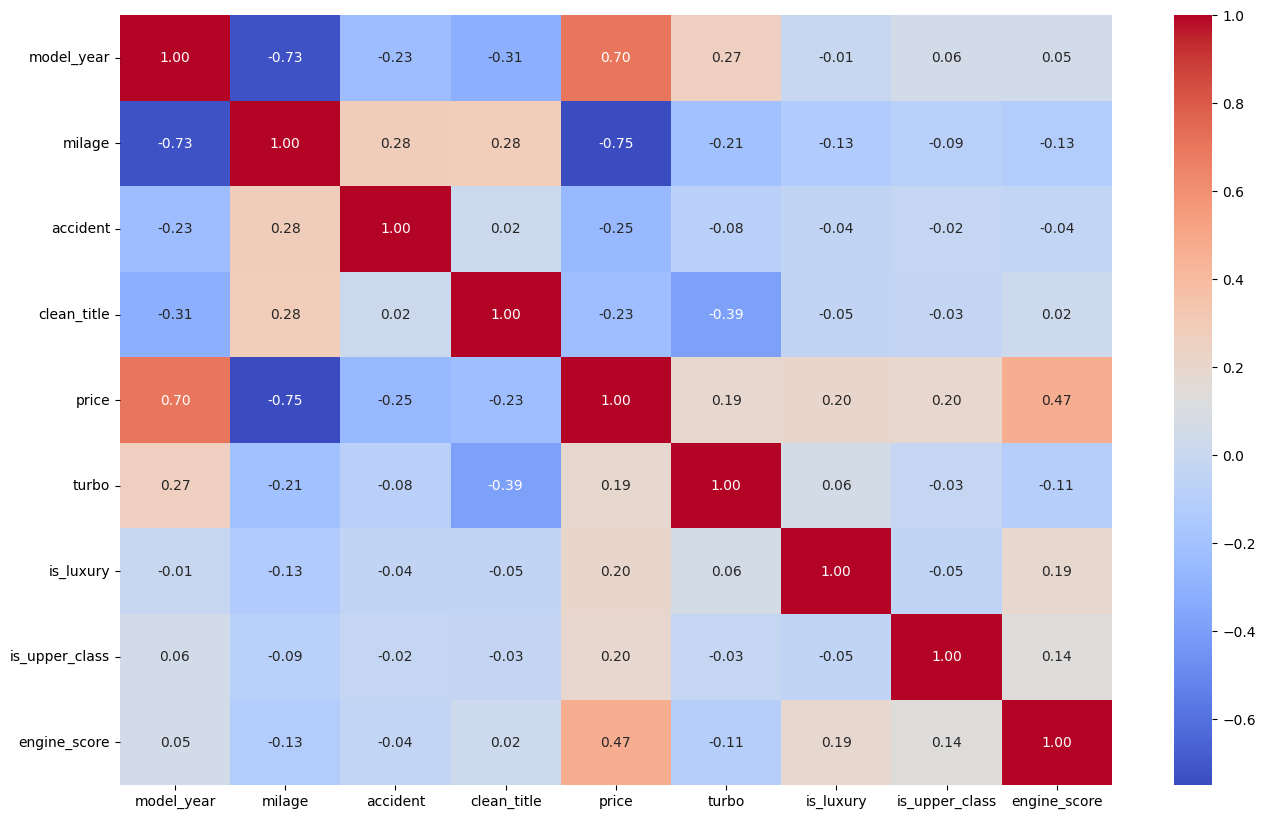

In [73]:
dataset = datasets[0] # Use the original training dataset

# Calculate the Spearman correlation
spearman_corr = dataset.corr(method='spearman')

# Plot the correlation matrix
plt.figure(figsize=(16, 10))
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap='coolwarm')

### Persist preprocessed data

In [74]:
# Save the preprocessed dataset
datasets[0].to_csv('./data/1_Preprocessing/train.csv', index=False)
datasets[1].to_csv('./data/1_Preprocessing/train_generated_and_original.csv', index=False)
datasets[2].to_csv('./data/1_Preprocessing/test.csv', index=False)